# Applied Data Science Capstone - Cousera
-----

# Clustering the neighborhoods of Bangalore,IN based on Venue Information
*****

### Import required libraries for data handling

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

### Data Collection

In [2]:
# create beautiful Soup object to scrape geo-locations for Bangalore City
url='https://finkode.com/ka/bangalore.html'
r=requests.get(url)
soup=BeautifulSoup(r.text,'lxml')
match=soup.find('table',class_='plist')
tr=match.find_all('tr')

In [3]:
#creating 3 list objects to store locaion, city and PIN information
A=[]
B=[]
C=[]
for r in range(1,len(tr)):
    td=tr[r].find_all('td')
    for i, d in enumerate(td):
        if i==0:
            A.append(d.text.strip())
        elif i==1:
            B.append(d.text.strip())
        else:
            C.append(d.text.strip())

In [4]:
# Creating a panda dataframe from the captured list information
Df_Dict={'Neighborhood':A,'City':B,'Pincode':C}
DF=pd.DataFrame(Df_Dict)

In [5]:
# Using geopy library o get laitude, longitude details
from geopy.geocoders import Nominatim
Lat=[]
Long=[]
locator = Nominatim(user_agent='myGeocoder')
for p in zip(DF.Pincode):
    location = locator.geocode(p)
    if location is not None:
        Lat.append(location.latitude) 
        Long.append(location.longitude)
    else:
        Lat.append(0)
        Long.append(0)

In [6]:
# Adding Laitude & Longitude information to the panda dataframe
DF['Latitude']=Lat
DF['Longitude']=Long
DF=DF[DF['Latitude']!=0].reset_index(None)
DF.drop_duplicates(['Latitude'],keep='first',inplace=True)

### Data Manipulation/ Data Cleaning

In [7]:
# Several locations yielded in inaccurate latitude and logiude data, we use the Inter-quartile range to remove the outliers based on the latitude info
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    low  = q1-(1.5*iqr)
    high = q3+(1.5*iqr)
    df_out = df_in.loc[(df_in[col_name] >low) & (df_in[col_name] < high)]
    return df_out

DF=remove_outlier(DF, 'Latitude')
DF.reset_index(None,inplace=True)
DF.drop(['level_0','index'],axis=1,inplace=True)

### Fourquare API Data

In [8]:
# Define data parameters
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = 'X' # your Foursquare Secret
VERSION = '20200504' # Foursquare API version
LIMIT=100 #Set Limit
radius=1000 #set radius of search

In [9]:
#Function to fecth venue details for each geo-locaion
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
#Get venue details
Bangalore_venues = getNearbyVenues(names=DF['Neighborhood'],
                                   latitudes=DF['Latitude'],
                                   longitudes=DF['Longitude']
                                  )

A F Station Yelahanka S.O
Adugodi S.O
Agram S.O
Amruthahalli B.O
Anandnagar S.O (Bangalore)
Arabic College S.O
Ashoknagar S.O (Bangalore)
Attur B.O
Austin Town S.O
B Sk II Stage S.O
Bagalur S.O (Bangalore)
Banashankari III Stage S.O
Banaswadi S.O
Bangalore City S.O
Bangalore Dist Offices Bldg S.O
Bannerghatta Road S.O
Bannerghatta S.O
Bapagrama B.O
Basavanagudi H.O
Basaveshwaranagar S.O
Begur B.O
Benson Town S.O
Bnagalore Viswavidalaya S.O
Bolare B.O
Bommasandra Industrial Estate S.O
C.V.Raman Nagar S.O
Carmelaram S.O
Chamarajasagara B.O
Chamrajpet S.O (Bangalore)
Chandra Lay Out S.O
Chickpet S.O
Chikkabettahalli B.O
Chikkalasandra S.O
Chudenapura B.O
CMP Centre And School S.O
Deepanjalinagar S.O
Devanagundi B.O
Devasandra S.O
Dharmaram College S.O
Doddakallasandra S.O
Doddanekkundi B.O
Domlur S.O
Dommasandra B.O
Doorvaninagar S.O
Dr. Shivarama Karanth Nagar S.O
Electronics City S.O
G.K.V.K. S.O
Gaviopuram Extension S.O
Gayathrinagar S.O
Gunjur B.O
H.A.L II Stage H.O
H.K.P. Road S.O
Ha

### Remove neighborhoods with less than 10 venues from the Initial list

In [16]:
Venue_list=Bangalore_venues[['Neighborhood','Venue Category']].groupby('Neighborhood').count()
No_ten_Venue=Venue_list[Venue_list['Venue Category']<10]
Venue_list=Venue_list[Venue_list['Venue Category']>=10]
DF_new=DF[DF['Neighborhood'].isin(Venue_list.index)].reset_index(drop=True)
Bangalore_venues=Bangalore_venues[Bangalore_venues['Neighborhood'].isin(Venue_list.index)].reset_index(drop=True)

### Analysing Each neigborhood

In [17]:
# one hot encoding
Bangalore_onehot = pd.get_dummies(Bangalore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Bangalore_onehot['Neighborhood'] = Bangalore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Bangalore_onehot.columns[-1]] + list(Bangalore_onehot.columns[:-1])
Bangalore_onehot = Bangalore_onehot[fixed_columns]

In [18]:
Bangalore_grouped = Bangalore_onehot.groupby('Neighborhood').mean().reset_index()

### Let's print each neighborhood along with the top 10 most common venues

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Bangalore_grouped['Neighborhood']

for ind in np.arange(Bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Bangalore_grouped.iloc[ind, :], num_top_venues)
    
    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amruthahalli B.O,Ice Cream Shop,Italian Restaurant,Resort,Café,Sandwich Place,Snack Place,Bakery,Badminton Court,Coffee Shop,Arts & Crafts Store
1,B Sk II Stage S.O,Fast Food Restaurant,Indian Restaurant,Pizza Place,Ice Cream Shop,Café,Shopping Mall,Park,Clothing Store,Mobile Phone Shop,Pub
2,Banaswadi S.O,Fast Food Restaurant,Indian Restaurant,Steakhouse,Indian Chinese Restaurant,Electronics Store,Café,Jewelry Store,Gastropub,Women's Store,Farmers Market
3,Bangalore Dist Offices Bldg S.O,Indian Restaurant,Flea Market,Hotel,Bus Station,Seafood Restaurant,Dessert Shop,Bookstore,Fast Food Restaurant,Bed & Breakfast,Farmers Market
4,Bannerghatta Road S.O,Ice Cream Shop,Café,Sandwich Place,Fast Food Restaurant,Liquor Store,Indian Restaurant,Chinese Restaurant,Pizza Place,Department Store,South Indian Restaurant


### Cluster Neighborhoods using KMeans Clustering

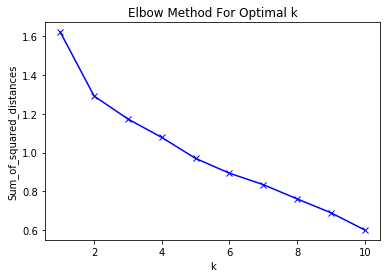

In [21]:
from sklearn.cluster import KMeans

# lets select the optimal K clusters
k=1
Bangalore_grouped_clustering = Bangalore_grouped.drop('Neighborhood', 1)
sum_of_squared_distance=[]
for k in np.arange(1,11,1):
    km=KMeans(n_clusters=k,random_state=0)
    km.fit(Bangalore_grouped_clustering)
    sum_of_squared_distance.append(km.inertia_)
    

    
# Visualize the squares distances using he elbow diagram -----> in turn helping us to choose the optimal K clusters

plt.plot(np.arange(1,11,1), sum_of_squared_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
# set number of clusters
kclusters = 2



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0], dtype=int32)

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Bangalore_merged = DF_new

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Bangalore_merged = Bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [24]:
# Install Folium Package
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

In [25]:
# create map
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
#lat,long of torans ato
address = 'Bangalore, IN'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#create a folium chart
map_clusters=folium.Map(location=[latitude,longitude],zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Bangalore_merged['Latitude'], Bangalore_merged['Longitude'], Bangalore_merged['Neighborhood'], Bangalore_merged['Cluster Labels'].astype('int')):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining cluster 1

In [27]:
Bangalore_merged.loc[Bangalore_merged['Cluster Labels'] == 1, Bangalore_merged.columns[[0] + list(range(5, Bangalore_merged.shape[1]))]]

# On examing the cluster 1 it is very evident it constitues a lot of Indian restuarants, Family & multi-cuisine restuarants, 
# Departmental stores etc.

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,B Sk II Stage S.O,1,Fast Food Restaurant,Indian Restaurant,Pizza Place,Ice Cream Shop,Café,Shopping Mall,Park,Clothing Store,Mobile Phone Shop,Pub
2,Banaswadi S.O,1,Fast Food Restaurant,Indian Restaurant,Steakhouse,Indian Chinese Restaurant,Electronics Store,Café,Jewelry Store,Gastropub,Women's Store,Farmers Market
3,Bangalore Dist Offices Bldg S.O,1,Indian Restaurant,Flea Market,Hotel,Bus Station,Seafood Restaurant,Dessert Shop,Bookstore,Fast Food Restaurant,Bed & Breakfast,Farmers Market
5,Basavanagudi H.O,1,Indian Restaurant,Fast Food Restaurant,Tea Room,Snack Place,Metro Station,Sandwich Place,Food,Restaurant,Juice Bar,Café
6,Basaveshwaranagar S.O,1,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Gastropub,Snack Place,Sandwich Place,Karnataka Restaurant,Juice Bar,Asian Restaurant,Burger Joint
7,C.V.Raman Nagar S.O,1,Indian Restaurant,Pizza Place,Café,Trail,Food Truck,Department Store,Restaurant,Women's Store,Farmers Market,Electronics Store
9,Chikkalasandra S.O,1,Indian Restaurant,Department Store,Café,Paintball Field,Bakery,Fast Food Restaurant,Gym,Pizza Place,Cupcake Shop,Deli / Bodega
11,Domlur S.O,1,Indian Restaurant,Hotel,Pizza Place,Chinese Restaurant,Bookstore,Pharmacy,Pub,Café,Shoe Store,Breakfast Spot
15,Immedihalli B.O,1,Indian Restaurant,Pizza Place,Ice Cream Shop,BBQ Joint,Fast Food Restaurant,Bookstore,Sandwich Place,Café,Shopping Mall,Chinese Restaurant
18,Koramangala VI Bk S.O,1,Indian Restaurant,Chinese Restaurant,Café,Dessert Shop,Lounge,Pub,Restaurant,Snack Place,Ice Cream Shop,Bookstore


In [28]:
Bangalore_merged.loc[Bangalore_merged['Cluster Labels'] == 0, Bangalore_merged.columns[[0] + list(range(5, Bangalore_merged.shape[1]))]]

# On examing the cluster 0 it is very evident it constitues a lot of fast food restuarants, Ice cream parlours, cafe, pubs & Sports & 
# Recreational places. 


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amruthahalli B.O,0,Ice Cream Shop,Italian Restaurant,Resort,Café,Sandwich Place,Snack Place,Bakery,Badminton Court,Coffee Shop,Arts & Crafts Store
4,Bannerghatta Road S.O,0,Ice Cream Shop,Café,Sandwich Place,Fast Food Restaurant,Liquor Store,Indian Restaurant,Chinese Restaurant,Pizza Place,Department Store,South Indian Restaurant
8,Chickpet S.O,0,Italian Restaurant,Café,Mexican Restaurant,Lounge,Hotel,Coffee Shop,Restaurant,Electronics Store,Japanese Restaurant,Rajasthani Restaurant
10,CMP Centre And School S.O,0,Café,Hotel,Indian Restaurant,Clothing Store,Pub,Bakery,Brewery,Donut Shop,Bar,Sandwich Place
12,Electronics City S.O,0,Hotel,Café,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Tea Room,Indian Restaurant,Deli / Bodega,Cupcake Shop
13,H.A.L II Stage H.O,0,Indian Restaurant,Pub,Café,Restaurant,Vietnamese Restaurant,Italian Restaurant,Tea Room,Lounge,Mexican Restaurant,Candy Store
14,Hoodi B.O,0,Coffee Shop,Auto Workshop,Cafeteria,Breakfast Spot,Café,Sporting Goods Shop,Bakery,Office,Grocery Store,Gym
16,Indiranagar S.O (Bangalore),0,Indian Restaurant,Café,Pub,Vegetarian / Vegan Restaurant,Pizza Place,Fast Food Restaurant,Dessert Shop,Restaurant,Andhra Restaurant,Chinese Restaurant
17,Jayanagar H.O,0,Indian Restaurant,Multiplex,Pharmacy,Gym,Cupcake Shop,Pub,Department Store,Bakery,Café,Donut Shop
20,Malleswaram S.O,0,Ice Cream Shop,Bakery,Pharmacy,Department Store,Light Rail Station,Breakfast Spot,Social Club,Food Truck,Park,Vegetarian / Vegan Restaurant
